# Censoring - Runner Stays on Third


## Problem

We need a stochastic method for determining if a runner that stayed would have
been tagged out.

## Hypothesis

The tagged out outcome follows a normal distribution and a normal distribution
can be fitted to the data to get the one sided confidence interval. The one-sided
confidence interval can be used to determine if a stay would have been an out or
the stay would have been not a tag out.

In [72]:
import random
import polars as pl
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.stats import norm

random.seed(123)

## Data Prep

In [73]:
# Lazy read the data
on_base_lf = pl.scan_parquet("../data/throw_home_runner_on_third_wide_sprint_arm.parquet")

# Create and clean a dataset for runners tagged out
out_lf = (on_base_lf
              .select(["is_out", "distance_catch_to_home"])
              .filter(pl.col("is_out") == True)
              .drop(["is_out"])
              .with_columns(pl.lit("Out").alias("outcome"))
              .drop_nulls(pl.all())
)

# Create and clean a dataset for runners that scored
scored_lf = (on_base_lf
          .select(["is_advance", "distance_catch_to_home"])
          .filter(pl.col("is_advance") == True)
          .drop(["is_advance"])
          .with_columns(pl.lit("Scored").alias("outcome"))
          .drop_nulls(pl.all())
)

# Create and clean a dataset for runners that stayed
stayed_lf = (on_base_lf
          .select(["is_stay", "distance_catch_to_home"])
          .filter(pl.col("is_stay") == True)
          .drop(["is_stay"])
          .with_columns(pl.lit("Stay").alias("outcome"))
          .drop_nulls(pl.all())
)

# Combine all datasets
combined_lf = pl.concat([out_lf, scored_lf, stayed_lf])
combined_pd = combined_lf.collect().to_pandas()
combined_pd

,distance_catch_to_home,outcome
0,264.394729,Out
1,253.113036,Out
2,237.698864,Out
3,253.476871,Out
4,254.035708,Out
...,...,...
6191,225.735989,Stay
6192,222.955221,Stay
6193,293.638466,Stay
6194,224.625747,Stay


In [85]:
out_np = out_lf.select(["distance_catch_to_home"]).collect().to_numpy().flatten()

def bootstrap_upper_one_sided_ci(data, confidence=0.95, n_bootstrap=10000):
    """
    """
    bootstrap_means = []
    n = len(data)
    ci = confidence * 100
    
    for _ in range(n_bootstrap):
        sample = np.random.choice(data, size=n, replace=True)
        bootstrap_means.append(np.mean(sample))
    
    bound = np.percentile(bootstrap_means, ci)
    print(f"One-sided 95% CI: mean ≤ {bound:.2f}")
    
    return bootstrap_means, bound

bootstrap_means, bound = bootstrap_upper_one_sided_ci(out_np)

One-sided 95% CI: mean ≤ 259.73


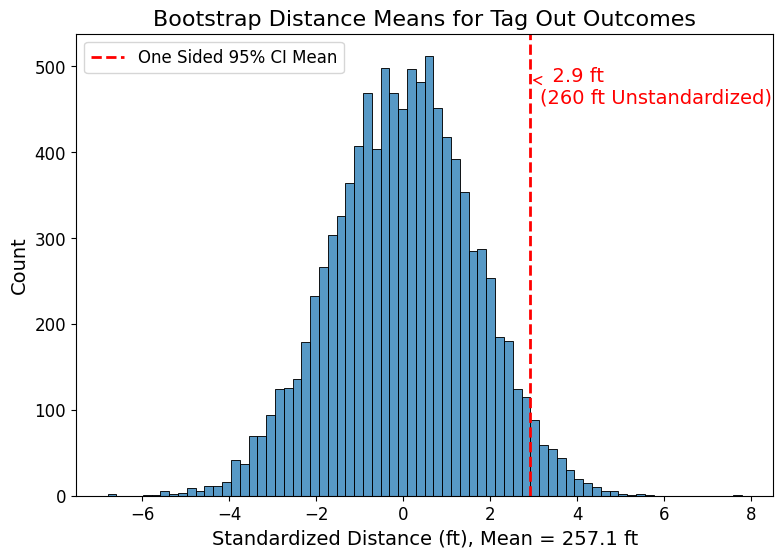

In [125]:
bootstrap_means_centered = bootstrap_means - np.mean(bootstrap_means)
reference_line = 260 - np.mean(bootstrap_means)
mean_value = np.mean(bootstrap_means)

plt.figure(figsize=(9, 6))
sns.histplot(bootstrap_means_centered)
plt.axvline(x=reference_line, color='red', linestyle='--', linewidth=2)
plt.annotate(f'  {reference_line:.1f} ft\n(260 ft Unstandardized)', 
           xy=(reference_line, plt.ylim()[1] * 0.90),  
           xytext=(reference_line + 0.25, plt.ylim()[1] * 0.85),  
           arrowprops=dict(arrowstyle='->', color='red'),
           fontsize=14,
           color='red')

# Create legend handles
from matplotlib.lines import Line2D
vline_handle = Line2D([0], [0], color='red', linestyle='--', linewidth=2)

# Add to legend with standardization info
plt.legend([vline_handle], 
          [f'One Sided 95% CI Mean'], 
          loc='upper left', 
          fontsize=12, 
          title_fontsize=14)

plt.title('Bootstrap Distance Means for Tag Out Outcomes', fontsize=16)
plt.ylabel('Count', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel(f'Standardized Distance (ft), Mean = {mean_value:.1f} ft', fontsize=14)
plt.show()

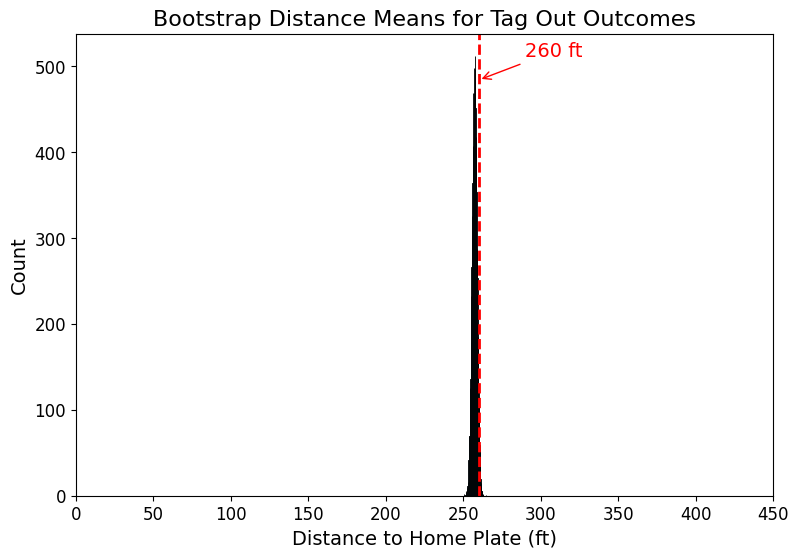

In [93]:
# Create stacked histogram
plt.figure(figsize=(9, 6))
sns.histplot(bootstrap_means)

# Add vertical line and plot annotation
plt.axvline(x=260, color='red', linestyle='--', linewidth=2)
plt.annotate('260 ft', 
           xy=(260, plt.ylim()[1] * 0.90),  
           xytext=(260 + 30, plt.ylim()[1] * 0.95),  
           arrowprops=dict(arrowstyle='->', color='red'),
           fontsize=14,
           color='red')

# Plot Formatting
plt.title('Bootstrap Distance Means for Tag Out Outcomes', fontsize=16)
plt.xlabel('Distance to Home Plate (ft)', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(0, 450)

plt.show()

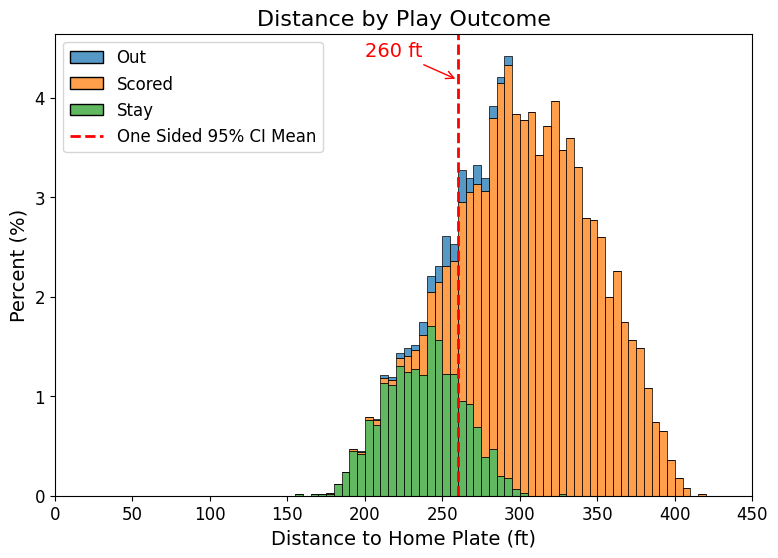

In [98]:
# Create stacked histogram
plt.figure(figsize=(9, 6))
ax = sns.histplot(data=combined_pd, 
                 x="distance_catch_to_home", 
                 hue="outcome",
                 stat="percent", 
                 binrange=(0, 450),
                 binwidth=5,
                 multiple="stack")

# Add vertical line and plot annotation
plt.axvline(x=260, color='red', linestyle='--', linewidth=2)
plt.annotate('260 ft', 
           xy=(260, plt.ylim()[1] * 0.90),  
           xytext=(260 - 60, plt.ylim()[1] * 0.95),  
           arrowprops=dict(arrowstyle='->', color='red'),
           fontsize=14,
           color='red')

# Save the legend for later
legend = ax.get_legend()
handles = legend.legend_handles
labels = [t.get_text() for t in legend.get_texts()]

# Add the vertical line to the legend
vline_handle = Line2D([0], [0], color='red', linestyle='--', linewidth=2)
handles.append(vline_handle)
labels.append('One Sided 95% CI Mean')

# Create legend with each part
plt.legend(handles, labels, loc='upper left', fontsize=12, title_fontsize=14)

# Plot Formatting
plt.title('Distance by Play Outcome', fontsize=16)
plt.xlabel('Distance to Home Plate (ft)', fontsize=14)
plt.ylabel('Percent (%)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(0, 450)

plt.show()

In [76]:
combined_censored_lf = combined_lf.with_columns(
    pl.when((pl.col("outcome") == pl.lit("Stay")) & (pl.col("distance_catch_to_home") <= 260))
    .then(pl.lit("Out"))
    .otherwise(pl.col("outcome"))
    .alias("outcome")
)
combined_censored_pd = combined_censored_lf.collect().to_pandas()

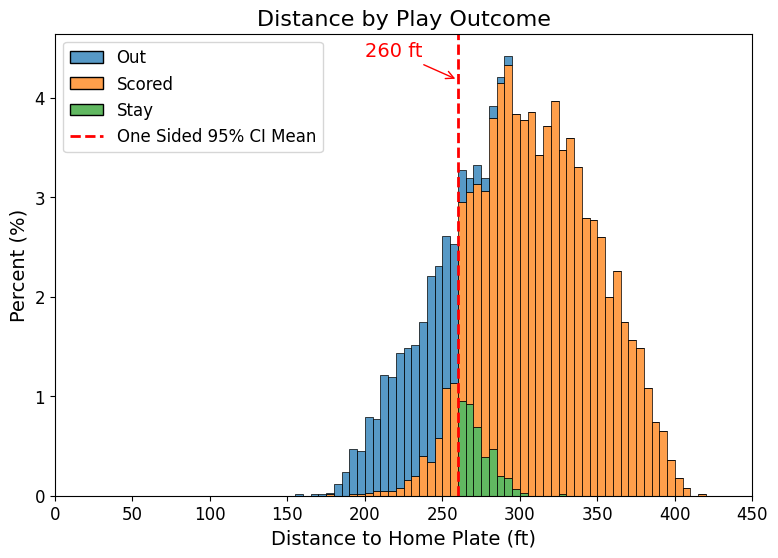

In [99]:
# Create stacked histogram
plt.figure(figsize=(9, 6))
ax = sns.histplot(data=combined_censored_pd, 
                 x="distance_catch_to_home", 
                 hue="outcome",
                 stat="percent", 
                 binrange=(0, 450),
                 binwidth=5,
                 multiple="stack")

# Add vertical line and plot annotation
plt.axvline(x=260, color='red', linestyle='--', linewidth=2)
plt.annotate('260 ft', 
           xy=(260, plt.ylim()[1] * 0.90),  
           xytext=(260 - 60, plt.ylim()[1] * 0.95),  
           arrowprops=dict(arrowstyle='->', color='red'),
           fontsize=14,
           color='red')

# Save the legend for later
legend = ax.get_legend()
handles = legend.legend_handles
labels = [t.get_text() for t in legend.get_texts()]

# Add the vertical line to the legend
vline_handle = Line2D([0], [0], color='red', linestyle='--', linewidth=2)
handles.append(vline_handle)
labels.append('One Sided 95% CI Mean')

# Create legend with each part
plt.legend(handles, labels, loc='upper left', fontsize=12, title_fontsize=14)

# Plot Formatting
plt.title('Distance by Play Outcome', fontsize=16)
plt.xlabel('Distance to Home Plate (ft)', fontsize=14)
plt.ylabel('Percent (%)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(0, 450)

plt.show()

In [129]:
combined_binary_lf = (combined_lf
    .with_columns(
        pl.when(pl.col("outcome") != pl.lit("Out"))
        .then(pl.lit("Not Out"))
        .otherwise(pl.col("outcome"))
        .alias("outcome")
    )
) 

combined_binary_pd = combined_binary_lf.collect().to_pandas()

combined_censored_binary_lf = (combined_lf
    .with_columns(
        pl.when((pl.col("outcome") == pl.lit("Stay")) & (pl.col("distance_catch_to_home") <= 260))
        .then(pl.lit("Out"))
        .otherwise(pl.col("outcome"))
        .alias("outcome"))
    .with_columns(
        pl.when(pl.col("outcome") != pl.lit("Out"))
        .then(pl.lit("Not Out"))
        .otherwise(pl.col("outcome"))
        .alias("outcome")
    )
)

combined_censored_binary_pd = combined_censored_binary_lf.collect().to_pandas()

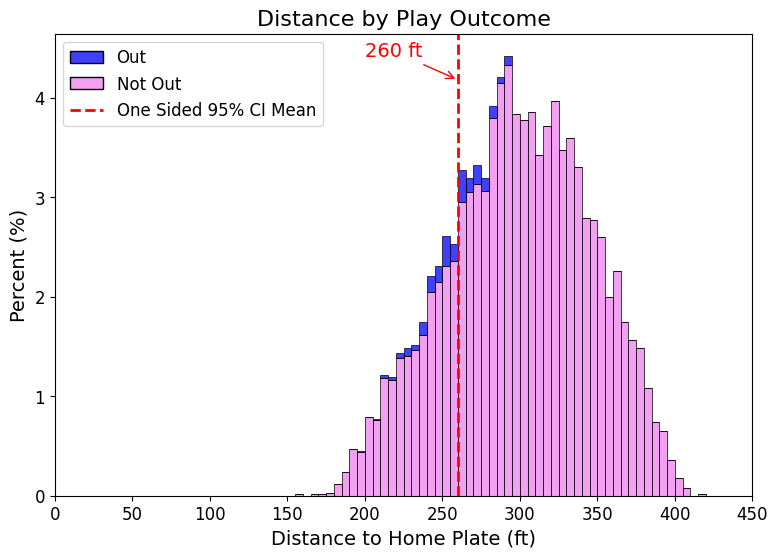

In [141]:
# Create stacked histogram
plt.figure(figsize=(9, 6))
ax = sns.histplot(data=combined_binary_pd, 
                 x="distance_catch_to_home", 
                 hue="outcome",
                 stat="percent", 
                 binrange=(0, 450),
                 binwidth=5,
                 palette=["blue", "violet"],
                 multiple="stack")

# Add vertical line and plot annotation
plt.axvline(x=260, color='red', linestyle='--', linewidth=2)
plt.annotate('260 ft', 
           xy=(260, plt.ylim()[1] * 0.90),  
           xytext=(260 - 60, plt.ylim()[1] * 0.95),  
           arrowprops=dict(arrowstyle='->', color='red'),
           fontsize=14,
           color='red')

# Save the legend for later
legend = ax.get_legend()
handles = legend.legend_handles
labels = [t.get_text() for t in legend.get_texts()]

# Add the vertical line to the legend
vline_handle = Line2D([0], [0], color='red', linestyle='--', linewidth=2)
handles.append(vline_handle)
labels.append('One Sided 95% CI Mean')

# Create legend with each part
plt.legend(handles, labels, loc='upper left', fontsize=12, title_fontsize=14)

# Plot Formatting
plt.title('Distance by Play Outcome', fontsize=16)
plt.xlabel('Distance to Home Plate (ft)', fontsize=14)
plt.ylabel('Percent (%)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(0, 450)

plt.show()

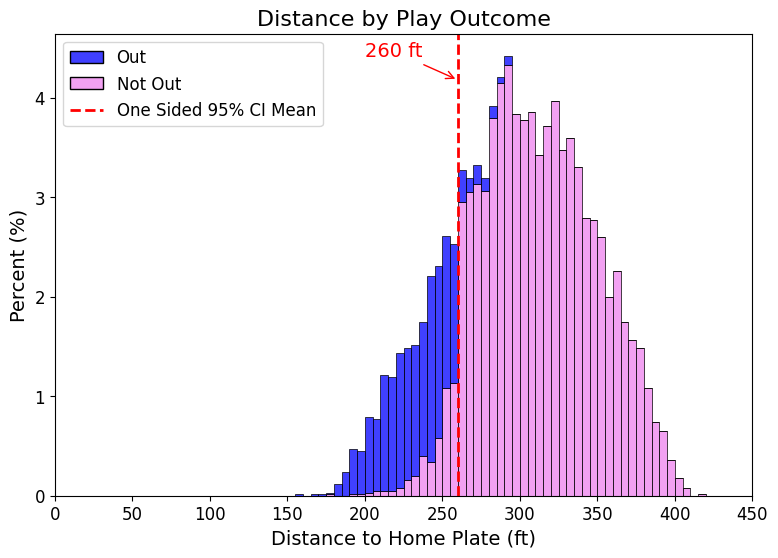

In [142]:
# Create stacked histogram
plt.figure(figsize=(9, 6))
ax = sns.histplot(data=combined_censored_binary_pd, 
                 x="distance_catch_to_home", 
                 hue="outcome",
                 stat="percent", 
                 binrange=(0, 450),
                 binwidth=5,
                 palette=["blue", "violet"],
                 multiple="stack")

# Add vertical line and plot annotation
plt.axvline(x=260, color='red', linestyle='--', linewidth=2)
plt.annotate('260 ft', 
           xy=(260, plt.ylim()[1] * 0.90),  
           xytext=(260 - 60, plt.ylim()[1] * 0.95),  
           arrowprops=dict(arrowstyle='->', color='red'),
           fontsize=14,
           color='red')

# Save the legend for later
legend = ax.get_legend()
handles = legend.legend_handles
labels = [t.get_text() for t in legend.get_texts()]

# Add the vertical line to the legend
vline_handle = Line2D([0], [0], color='red', linestyle='--', linewidth=2)
handles.append(vline_handle)
labels.append('One Sided 95% CI Mean')

# Create legend with each part
plt.legend(handles, labels, loc='upper left', fontsize=12, title_fontsize=14)

# Plot Formatting
plt.title('Distance by Play Outcome', fontsize=16)
plt.xlabel('Distance to Home Plate (ft)', fontsize=14)
plt.ylabel('Percent (%)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(0, 450)

plt.show()

In [147]:

combined_censored_binary_lf = (combined_lf
    .with_columns(
        pl.when((pl.col("outcome") == pl.lit("Stay")) | (pl.col("outcome") == pl.lit("Out")))
        .then(pl.lit("Stay or Out"))
        .otherwise(pl.col("outcome"))
        .alias("outcome"))
    .with_columns(
        pl.when(pl.col("outcome") != pl.lit("Stay or Out"))
        .then(pl.lit("Scored"))
        .otherwise(pl.col("outcome"))
        .alias("outcome")
    )
)

combined_censored_binary_pd = combined_censored_binary_lf.collect().to_pandas()

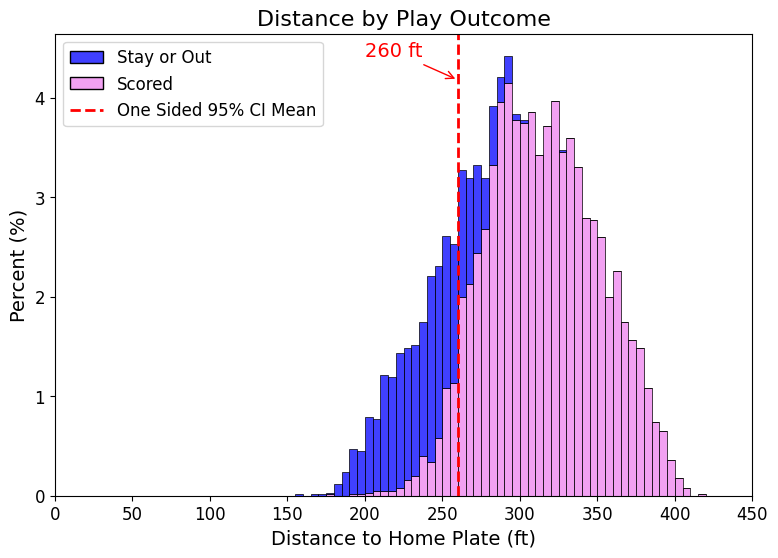

In [148]:
# Create stacked histogram
plt.figure(figsize=(9, 6))
ax = sns.histplot(data=combined_censored_binary_pd, 
                 x="distance_catch_to_home", 
                 hue="outcome",
                 stat="percent", 
                 binrange=(0, 450),
                 binwidth=5,
                 palette=["blue", "violet"],
                 multiple="stack")

# Add vertical line and plot annotation
plt.axvline(x=260, color='red', linestyle='--', linewidth=2)
plt.annotate('260 ft', 
           xy=(260, plt.ylim()[1] * 0.90),  
           xytext=(260 - 60, plt.ylim()[1] * 0.95),  
           arrowprops=dict(arrowstyle='->', color='red'),
           fontsize=14,
           color='red')

# Save the legend for later
legend = ax.get_legend()
handles = legend.legend_handles
labels = [t.get_text() for t in legend.get_texts()]

# Add the vertical line to the legend
vline_handle = Line2D([0], [0], color='red', linestyle='--', linewidth=2)
handles.append(vline_handle)
labels.append('One Sided 95% CI Mean')

# Create legend with each part
plt.legend(handles, labels, loc='upper left', fontsize=12, title_fontsize=14)

# Plot Formatting
plt.title('Distance by Play Outcome', fontsize=16)
plt.xlabel('Distance to Home Plate (ft)', fontsize=14)
plt.ylabel('Percent (%)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(0, 450)

plt.show()